# Определение возраста покупателей

Описание проекта: 

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:   
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.   

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.   

Инструкция по выполнению проекта   

* Проведите исследовательский анализ набора фотографий.   
* Подготовьте данные к обучению.   
* Обучите нейронную сеть и рассчитайте её качество.   

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


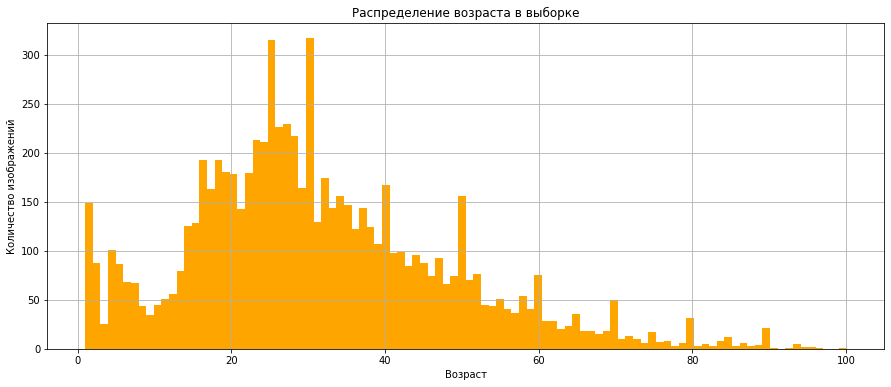

In [15]:
#import matplotlib.pyplot as plt

# Построение графика распределения возраста в выборке
plt.figure(figsize=(15, 6))
labels['real_age'].hist(bins=100, color='orange')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

In [4]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

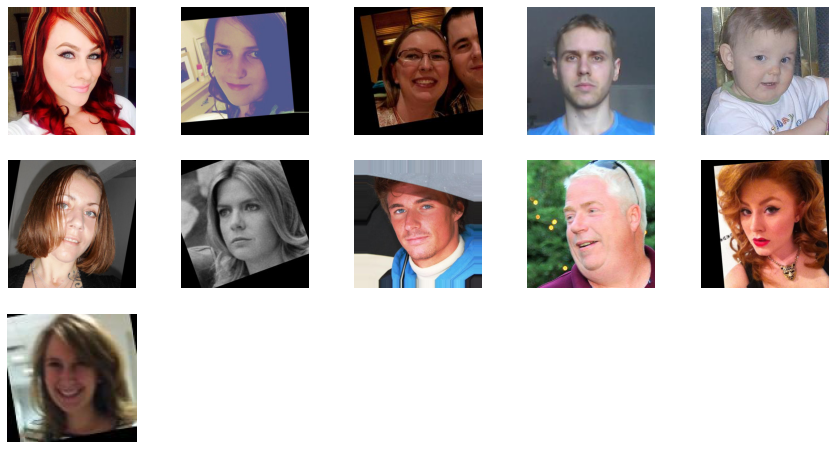

In [5]:
#import random
#import matplotlib.image as mpimg

# Случайный выбор 10-15 фотографий из датасета
image_samples = random.sample(labels['file_name'].tolist(), random.randint(10, 15))

# Вывод выбранных фотографий на экран
plt.figure(figsize=(15, 8))
for i, image_path in enumerate(image_samples):
    plt.subplot(3, 5, i+1)
    img = mpimg.imread('/datasets/faces/final_files/' + image_path)
    plt.imshow(img)
    plt.axis('off')

plt.show()

Посмотрели данные согласно инструкции. Всего у нас 7591 фотография. Взраст покупателей в основном средний. В среднем нашим покупателям где-то от 18 до 40 лет. Фотографии честно говоря достаточно странные. Черно-белые, кривые, косые.. При одной итерации даже попалась фотка с младенцем на руках.. Видимо поэтому у нас есть покупатель которому 1 год. Попробуем обучить нашу модель, посмотрим на показатели. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow

def load_test(path):
    
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    labels = pd.read_csv(path + 'labels.csv')
    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return val_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))   
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >


Train for 178 steps, validate for 60 steps
Epoch 1/7
2024-04-27 13:35:25.904678: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-27 13:35:26.337567: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 71s - loss: 223.8089 - mean_absolute_error: 10.6822 - val_loss: 688.3009 - val_mean_absolute_error: 21.2865
Epoch 2/7
178/178 - 41s - loss: 59.1829 - mean_absolute_error: 5.8591 - val_loss: 929.4727 - val_mean_absolute_error: 25.6853
Epoch 3/7
178/178 - 41s - loss: 30.0733 - mean_absolute_error: 4.2209 - val_loss: 405.0007 - val_mean_absolute_error: 15.1771
Epoch 4/7
178/178 - 39s - loss: 18.0835 - mean_absolute_error: 3.2957 - val_loss: 110.1215 - val_mean_absolute_error: 7.9439
Epoch 5/7
178/178 - 39s - loss: 14.2763 - mean_absolute_error: 2.9282 - val_loss: 82.5354 - val_mean_absolute_error: 6.9202
Epoch 6/7
178/178 - 40s - loss: 12.0275 - mean_absolute_error: 2.6600 - val_loss: 71.2639 - val_mean_absolute_error: 6.3263
Epoch 7/7
178/178 - 45s - loss: 10.1664 - mean_absolute_error: 2.4256 - val_loss: 66.3075 - val_mean_absolute_error: 6.1502
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 66.3075 - mean_absolute_error: 6.1502
Test MAE: 6.1502

```

## Анализ обученной модели

Анализ работы модели показывает, что она успешно обучается и с каждой эпохой демонстрирует улучшение основных показателей: среднеквадратичная ошибка (loss) и средняя абсолютная ошибка (mean_absolute_error) уменьшаются как на обучающих, так и на валидационных данных. Это указывает на то, что модель адаптируется и становится более точной в предсказании возраста по изображениям. Начальные этапы обучения показывают высокие значения потерь и ошибок, однако по мере продолжения процесса обучения показатели существенно улучшаются. Такое поведение модели является ожидаемым и свидетельствует о том, что алгоритм корректно обучается и оптимизирует свои веса для лучшего предсказания возраста.  

В конечном итоге, тестовое значение средней абсолютной ошибки (MAE) составило 6.1502, что является довольно низким показателем ошибки и свидетельствует об общей эффективности модели в предсказаниях на новых данных, не участвовавших в обучении. 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы